In [1]:
import os
import csv
import time
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr as pearr

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils as utils
import torch.nn.init as init

In [2]:
ob = open('../UTMOST_pred_result_data/tiss_R/tissuewise/Liver_observed_data.txt').readlines()
ob_list = ob[0].split()

pre = open('../UTMOST_pred_result_data/predicted_Liver.txt').readlines()
pre_list = pre[0].split()

print('observed sample # :', len(ob_list), ' / ', 'predicted sample # :', len(pre_list))

count = 0
ob_idx = []       ###  column
pre_idx = []      ###  column
ref_sample = []   ###  patient name
for k1 in range(1, len(ob_list)):
    if ob_list[k1][9]=='-':
        ref = ob_list[k1][:9]
    else:
        ref = ob_list[k1][:10]
        
    for k2 in range(len(pre_list)):
        pred = pre_list[k2]
        if ref==pred:
            count += 1
#             print(ref, pred, '//', k1, k2)
            ob_idx.append(k1)
            pre_idx.append(k2)
            ref_sample.append(ref)
            
print('(UTMOST) overlaped between observed and predicted sample # :', len(ref_sample))
print(ref_sample)

observed sample # : 189  /  predicted sample # : 867
(UTMOST) overlaped between observed and predicted sample # : 184
['GTEX-1192X', 'GTEX-11DXZ', 'GTEX-11EQ9', 'GTEX-11GSP', 'GTEX-11NUK', 'GTEX-11NV4', 'GTEX-11OF3', 'GTEX-11TT1', 'GTEX-11TUW', 'GTEX-11UD2', 'GTEX-11WQC', 'GTEX-11ZTS', 'GTEX-11ZUS', 'GTEX-11ZVC', 'GTEX-1212Z', 'GTEX-12696', 'GTEX-1269C', 'GTEX-12KS4', 'GTEX-12WSD', 'GTEX-12WSG', 'GTEX-12WSI', 'GTEX-12WSL', 'GTEX-12WSM', 'GTEX-12ZZZ', 'GTEX-13112', 'GTEX-13113', 'GTEX-131XE', 'GTEX-131XH', 'GTEX-131YS', 'GTEX-132AR', 'GTEX-132NY', 'GTEX-1399R', 'GTEX-1399T', 'GTEX-139TS', 'GTEX-139TU', 'GTEX-139UC', 'GTEX-139YR', 'GTEX-13FLV', 'GTEX-13FTW', 'GTEX-13FTZ', 'GTEX-13N11', 'GTEX-13N2G', 'GTEX-13NYB', 'GTEX-13NZ9', 'GTEX-13NZB', 'GTEX-13O3O', 'GTEX-13OVJ', 'GTEX-13OW6', 'GTEX-13PVQ', 'GTEX-13PVR', 'GTEX-13QJC', 'GTEX-13SLX', 'GTEX-13VXU', 'GTEX-13X6J', 'GTEX-144GL', 'GTEX-144GM', 'GTEX-145LU', 'GTEX-145MF', 'GTEX-145MO', 'GTEX-146FH', 'GTEX-14753', 'GTEX-147F4', 'GTEX-147GR',

In [3]:
a = open('Sample_Names_by_Tissue_by_Patient.csv')
reader = csv.reader(a)

count = 0
for plink_sample in reader:
    count += 1
    if count==1:
        break
        
print(len(ref_sample), len(ob_idx), len(pre_idx), len(plink_sample))

sorted_sample = []

sorted_idx_plink = []
sorted_idx_ob = []
sorted_idx_pre = []

for k1 in range(len(ref_sample)):
    dref_sample = ref_sample[k1]
    for k2 in range(1, len(plink_sample)):
        dplink_sample = plink_sample[k2]
        
        if dref_sample==dplink_sample:
            sorted_sample.append(dref_sample)
            
            sorted_idx_plink.append(k2)
            sorted_idx_ob.append(ob_idx[k1])
            sorted_idx_pre.append(pre_idx[k1])
            
print('sorted sample # :', len(sorted_sample))
print('snp data sample index # :', len(sorted_idx_plink))
np.save('sorted_sample_idx.npy', sorted_idx_plink)

184 184 184 621
sorted sample # : 155
snp data sample index # : 155


In [4]:
gene_ob_list = []
gene_pre_list = []

for k1 in range(len(ob)):
    g1 = ob[k1].split()[0]
    gene_ob_list.append(g1)

for k2 in range(len(pre)):
    g2 = pre[k2].split()[0]
    gene_pre_list.append(g2)

print('# of genes for observed / predicted :', len(gene_ob_list), ' / ', len(gene_pre_list))

gene_ob_idx = []
gene_pre_idx = []
gene_list = []
for k1 in range(len(gene_ob_list)):
    dgene_ob = gene_ob_list[k1]
    if k1%5000==0:
        print(k1)
        
    for k2 in range(len(gene_pre_list)):
        dgene_pre = gene_pre_list[k2]
        if dgene_ob==dgene_pre: 
            gene_ob_idx.append(k1)
            gene_pre_idx.append(k2)
            gene_list.append(dgene_ob)
            
print(len(gene_ob_idx), len(gene_pre_idx), len(gene_list))

# of genes for observed / predicted : 57820  /  10165
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
10145 10145 10145


/opt/anaconda3/envs/khj/lib/python3.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in float_scalars
  r = r_num / r_den


9916 9916


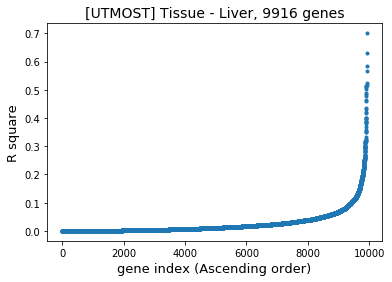

In [5]:
### check R square for all avaiilable gene
sorted_r_list = []
sorted_gene_list = []
sorted_gene_idx = []
for i in range(len(gene_list)):    
    aa = np.float32(np.array(ob[gene_ob_idx[i]].split())[sorted_idx_ob])
    bb = np.float32(np.array(pre[gene_pre_idx[i]].split())[sorted_idx_pre])
    if (np.sum(aa)*0 != 0) or (np.sum(bb)*0 != 0):
        continue
        
    r, p = pearr(aa, bb)
    if (r**2)*0!=0:
#         plt.plot(bb, aa,'*')
#         plt.title('R squre : %.4f / p %.4f'%(r**2, p))
#         plt.show()
        continue
    
    sorted_r_list.append(r**2)
    sorted_gene_list.append(gene_list[i])
    sorted_gene_idx.append(i)
        
print(len(sorted_r_list), len(sorted_gene_list))
plt.title('[UTMOST] Tissue - Liver, %d genes'%len(sorted_r_list),fontsize=14)
plt.plot(np.array(sorted_r_list)[np.argsort(sorted_r_list)], '.')
plt.xlabel('gene index (Ascending order)', fontsize=13)
plt.ylabel('R square', fontsize=13)
plt.savefig('img/UTMOST_allgene_Rsqr.png')
plt.show()

In [6]:
#### top 10 sorting code ##########

sorted_r_list = []
sorted_gene_list = []
sorted_gene_idx = []
for i in range(len(gene_list)):    
    aa = np.float32(np.array(ob[gene_ob_idx[i]].split())[sorted_idx_ob])
    bb = np.float32(np.array(pre[gene_pre_idx[i]].split())[sorted_idx_pre])
    if (np.sum(aa)*0 != 0) or (np.sum(bb)*0 != 0):
        continue
        
    r, p = pearr(aa, bb)
    if (r**2)*0!=0:
#         plt.plot(bb, aa,'*')
#         plt.title('R squre : %.4f / p %.4f'%(r**2, p))
#         plt.show()
        continue
    
    sorted_r_list.append(r**2)
    sorted_gene_list.append(gene_list[i])
    sorted_gene_idx.append(i)
    
#     if r**2>0.7:
#         plt.title('UTMOST - %s : %.5f'%(gene_list[i], r**2), fontsize=14)
#         plt.plot(bb, aa, 'r*')
#         plt.xlabel('Predicted expression', fontsize=13)
#         plt.ylabel('Observed expression', fontsize=13)
#         plt.savefig('img/Scatter_UTMOST_%s.png'%gene_list[i])
#         plt.show()
        
print(len(sorted_r_list), len(sorted_gene_list))

top_idx = np.argsort(sorted_r_list)[-10:]
top_r_list = np.array(sorted_r_list)[top_idx]
top_gene_list = np.array(sorted_gene_list)[top_idx]
for k in range(len(top_gene_list)):
    print(top_gene_list[k], ' = ', round(top_r_list[k], 4))
    
top_dict = dict(zip(top_gene_list, top_r_list))
print(top_dict)

json.dump(top_dict, open('top10_name2rsqr.json','w'))

9916 9916
PKN3  =  0.5024
THNSL2  =  0.5102
GSTT1  =  0.513
GSTT2  =  0.5132
DOPEY2  =  0.5159
XKR9  =  0.5257
C17orf97  =  0.5672
DDT  =  0.5834
PILRA  =  0.6287
FAM118A  =  0.7004
{'PKN3': 0.5023722014302621, 'THNSL2': 0.5102497471108478, 'GSTT1': 0.512989475717692, 'GSTT2': 0.5132431758329972, 'DOPEY2': 0.515921473961555, 'XKR9': 0.5257457796568623, 'C17orf97': 0.5672138929095496, 'DDT': 0.5833670780246827, 'PILRA': 0.6287449908122653, 'FAM118A': 0.700421157298706}


In [7]:
#### low 20 sorting code ##########

sorted_r_list = []
sorted_gene_list = []
sorted_gene_idx = []
for i in range(len(gene_list)):    
    aa = np.float32(np.array(ob[gene_ob_idx[i]].split())[sorted_idx_ob])
    bb = np.float32(np.array(pre[gene_pre_idx[i]].split())[sorted_idx_pre])
    if (np.sum(aa)*0 != 0) or (np.sum(bb)*0 != 0):
        continue
        
    r, p = pearr(aa, bb)
    if (r**2)*0!=0:
        continue

    sorted_r_list.append(r**2)
    sorted_gene_list.append(gene_list[i])
    sorted_gene_idx.append(i)
        
print(len(sorted_r_list), len(sorted_gene_list))

low_idx = np.argsort(sorted_r_list)[:20]
low_r_list = np.array(sorted_r_list)[low_idx]
low_gene_list = np.array(sorted_gene_list)[low_idx]
for k in range(len(low_gene_list)):
    print(low_gene_list[k])
    
low_dict = dict(zip(low_gene_list, low_r_list))
print(low_dict)

json.dump(low_dict, open('low20_name2rsqr.json','w'))

9916 9916
WDR83OS
ARFIP2
CDC42
PRR11
MON1B
HAND2
UBE2Z
MSANTD4
FAM3B
CPSF6
MRPL30
FN3K
RETSAT
PTMA
C5orf22
STK24
AGO4
C11orf86
HELQ
A1CF
{'WDR83OS': 5.236181788571504e-10, 'ARFIP2': 1.650370829798034e-09, 'CDC42': 2.3695180201015205e-09, 'PRR11': 5.717921506736564e-09, 'MON1B': 1.1491823133351733e-08, 'HAND2': 1.3396947689288139e-08, 'UBE2Z': 3.046629704135892e-08, 'MSANTD4': 3.743710995047652e-08, 'FAM3B': 5.4807221613569415e-08, 'CPSF6': 8.117601231571287e-08, 'MRPL30': 9.182293853805788e-08, 'FN3K': 9.288353838422578e-08, 'RETSAT': 1.0138397742883775e-07, 'PTMA': 1.0627395617601187e-07, 'C5orf22': 1.3050565269036364e-07, 'STK24': 1.3998721829151353e-07, 'AGO4': 1.4716953331322809e-07, 'C11orf86': 1.5828390669631073e-07, 'HELQ': 1.6332197274823192e-07, 'A1CF': 1.6676702298809173e-07}


In [8]:
####  sorting code ##########

sorted_r_list = []
sorted_gene_list = []
sorted_gene_idx = []
for i in range(len(gene_list)):    
    aa = np.float32(np.array(ob[gene_ob_idx[i]].split())[sorted_idx_ob])
    bb = np.float32(np.array(pre[gene_pre_idx[i]].split())[sorted_idx_pre])
    if (np.sum(aa)*0 != 0) or (np.sum(bb)*0 != 0):
        continue
        
    r, p = pearr(aa, bb)
    if (r**2)*0!=0:
        continue

    sorted_r_list.append(r**2)
    sorted_gene_list.append(gene_list[i])
    sorted_gene_idx.append(i)
        
print(len(sorted_r_list), len(sorted_gene_list))

low_idx = np.argsort(sorted_r_list)[::30]
low_r_list = np.array(sorted_r_list)[low_idx]
low_gene_list = np.array(sorted_gene_list)[low_idx]
for k in range(len(low_gene_list)):
    print(low_gene_list[k])
    
low_dict = dict(zip(low_gene_list, low_r_list))
print(low_dict)

json.dump(low_dict, open('over300_name2rsqr.json','w'))

9916 9916
WDR83OS
RIOK1
MIDN
PTPN23
THOC5
DCAF10
ADCY4
SMAD2
CAAP1
FAU
COL4A3BP
RPS3A
SNX9
GRPEL1
C2orf76
TNP1
EPS15
DTX3
PIK3C3
ORAOV1
MAGI3
NAGK
WISP3
UNC5B
PIK3R2
APH1B
TPSAB1
INSR
MTMR9
PPP1R35
HBG1
PIGX
ELMO3
ADO
SEC13
JRKL
THEM4
TRIM74
APPL2
C18orf8
PTEN
NSL1
MAPK8IP3
C16orf72
NR2F6
LYST
POU2F1
CASQ1
SPARC
LRPPRC
INPP4A
ADAMTSL4
C1orf162
RPAIN
TMEM204
DUSP10
CAPN2
ZNF142
MIS12
ZNF821
CPNE5
NARG2
RPS17
ALKBH4
ZNF33B
RDH14
SLC4A7
MCMDC2
BLOC1S1
COPB2
UGT3A2
B4GALT4
HSPA4
TMEM9B
ZNF414
OST4
P4HA3
TPD52
B3GAT3
E2F2
CTC1
MFAP3
SUMO4
UBE2V2
SMC4
PPP2R1A
ZNF429
SRSF9
ZNF793
RPS10
SMAD3
TACC2
ACTR2
PIWIL2
RPS6KB1
VAMP8
CEP290
KIAA1107
B3GNT5
ZNF530
PPP1R21
FAM3D
NEURL1B
BLZF1
PEX11G
NLE1
RBM4B
NUP37
SLC27A1
GLCE
AKTIP
RARA
NME6
SPTLC2
FAM200B
METTL14
ZNF566
TSEN54
KIAA0391
MRPL2
IRGQ
APOL6
COLCA2
TRIP4
ZG16B
TMEM150B
RANBP3
FAM214B
PRKCH
INADL
SPTBN2
MPST
KLHL8
ZHX3
SLC22A7
CYSTM1
CENPF
PRKCDBP
ZNF23
ACTR3C
ACOT4
DDX42
NME7
ABCA10
MICAL1
MTAP
FAM117A
EPHB1
PPP2R5A
ANAPC15
DCLRE1B
C12orf3